---
---

# Introducción aprendizaje no supervisado (Ejercicios)

---
## ¿Cómo detectar el número de *clusters*?

En la lección anterior, hemos visto cómo emplear diversos algoritmos para agrupar la información sin etiquetar. Sin embargo, un hecho relevante es tener una estimación de cuál sería el número óptimo de grupos presentes en nuestros datos *a priori*. Para analizar este problema, tomaremos como referencia un tipo de datos muy popular en aprendizaje no supervisado: la segmentación de clientes.

In [1]:
# Librería
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Leer fichero
df = pd.read_csv('https://raw.githubusercontent.com/sharmaroshan/Clustering-of-Mall-Customers/master/Mall_Customers.csv')
# Preprocesamiento
df.rename(index=str, columns={'Annual Income (k$)': 'Income',
                              'Spending Score (1-100)': 'Score',
                              'Genre': 'Gender'}, inplace=True)
df.head()

,CustomerID,Gender,Age,Income,Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Veamos cómo se compotan nuestras variables entre sí:

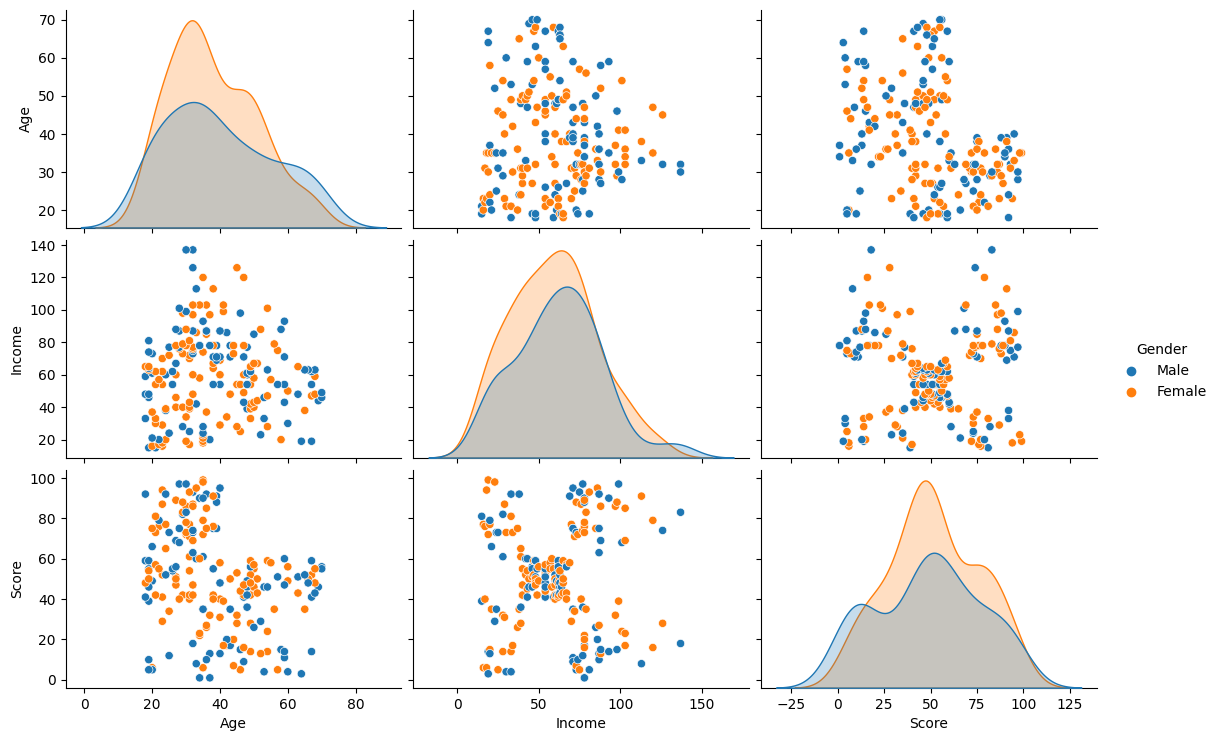

In [2]:
# Let's see our data in a detailed way with pairplot
X = df.drop(['CustomerID', 'Gender'], axis=1)
sns.pairplot(df.drop('CustomerID', axis=1), hue='Gender', aspect=1.5)
plt.show()

Puesto que el género no tiene un impacto directo en ninguna distribución, podemos eliminarlo.

Una vez hemos obtenidos las variables a emplear, procedemos a comentar el método que se emplea para calcular una estimación del número óptimo de *clusters*, conocido como método de *inercia*. En él, se estudia la suma de las distancias de todos los puntos al centroide del grupo al que pertenecen. A medida que aumentamos el número de *clusters*, naturalmente este número irá decreciendo, pero el problema será computacionalmente más costoso. Por ello, tendremos que encontrar un equilibrio entre ambas consideraciones, llegando a la *regla del codo* ó *elbow method*:

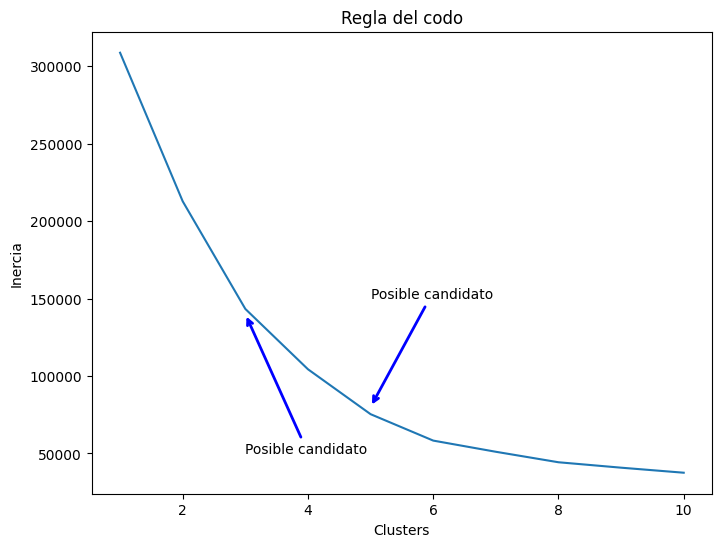

In [3]:
# Algoritmo sencillo de referencia para calcular la inercia
from sklearn.cluster import KMeans
# Acumulamos cantidades
clusters = []
# Bucle
for i in range(1, 11):
    km = KMeans(n_clusters=i).fit(X)
    clusters.append(km.inertia_)
# Dibujamos
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
ax.set_title('Regla del codo')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inercia')
# Annotate arrow
ax.annotate('Posible candidato', xy=(3, 140000), xytext=(3, 50000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))
ax.annotate('Posible candidato', xy=(5, 80000), xytext=(5, 150000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))
plt.show()

En este caso, es visible que un número razonable de *clusters* sería bien $3$ ó $5$.

El ejercicio consiste en implementar, de forma manual, este valor numérico. Tomaremos como referencia la implementación propia que hicimos en la anterior sesión y añadiremos un método extra que complemente el cálculo. Los pasos a seguir son:

1. Para cada cluster, tomamos el centroide (de `self.centroids`) y los puntos que pertenecen al mismo (de `self.clusters`).
2. Para cada cluster, calculamos la distancia de cada punto al centroide y las sumamos (sugerencia: cree una función lambda que permita fácilmente calcular la distancia de un vector a otro).
3. Sumamos las cantidades anteriores de caada *cluster*.

In [28]:
# Librerías
import numpy as np
from sklearn.datasets import make_blobs
from sklearn import datasets
import matplotlib.pyplot as plt

# Clase que contiene el algoritmo y funcionalidades extra
class KMeans:
    def __init__(self, K=5, max_iters=100, plot_steps=False):
        """Clase que contiene el algoritmo K-Means y funcionalidades
        adicionales. El método principal es "predict()", y "plot()" 
        sirve par agraficar los resultados, siendo el resto métodos
        auxiliares.

        Args:
            K (int, optional): Número de clusters. Defaults to 5.
            max_iters (int, optional): Número de iteraciones máximas. Defaults to 100.
            plot_steps (bool, optional): Dibujo en cada paso del análisis. Defaults to False.
        """
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps
        # Lista para contener los índices de cada cluster
        self.clusters = {idx:[] for idx in range(self.K)}
        # Lista de centroides
        self.centroids = []

    def predict(self, X):
        # Instanciamos en la clase algunos valores relevantes
        self.X = X
        self.n_samples, self.n_features = X.shape
        # Inicialización aleatoria de centroides
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace = False)
        self.centroids = [self.X[idx] for idx in random_sample_idxs]
        # Algoritmo
        for _ in range(self.max_iters):
            # Actualizamos clústeres
            self.clusters = self._create_clusters(self.centroids)
            if self.plot_steps:
                self.plot()
            # Actualizamos centroides
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)
            # Criterio de convergencia
            if self._is_converged(centroids_old, self.centroids):
                break
            # Dibujamos la evolución en esta iteración
            if self.plot_steps:
                self.plot()
        # Devolvemos las etiquetas resultantes
        return self._get_cluster_labels(self.clusters), self._inertia()

    def _inertia(self):
        return np.sum([np.sum([self.euclidean_distance(self.X[point],centroid) for point in km.clusters[idx]]) for idx, centroid in zip(range(len(km.centroids)),km.centroids)])

    def _get_cluster_labels(self, clusters):
        labels = np.empty(self.n_samples)
        for cluster_idx, cluster in clusters.items():
            for sample_idx in cluster:
                labels[sample_idx] = cluster_idx
        return labels

    def _create_clusters(self, centroids):
        clusters = {idx:[] for idx in range(self.K)}
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters

    def _closest_centroid(self, sample, centroids):
        distances = [self.euclidean_distance(sample,point) for point in centroids]
        closest_idx = np.argmin(distances)
        return closest_idx

    def _get_centroids(self, clusters):
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def _is_converged(self, centroids_old, centroids):
        distances = [self.euclidean_distance(centroids_old[i], centroids[i]) for i in range(self.K)]
        return sum(distances) == 0

    def plot(self):
        fig, ax = plt.subplots(figsize=(6,4))
        for i, index in self.clusters.items():
            point = self.X[index].T
            ax.scatter(*point)
        for point in self.centroids:
            ax.scatter(*point,marker='x',color='black',linewidth=2)
        plt.show()

    @staticmethod
    def euclidean_distance(x1,x2):
        return np.sqrt(np.sum((x1 - x2)**2))

[]

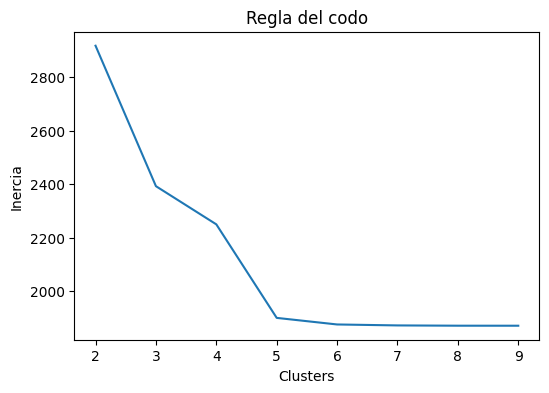

In [33]:
# Fijamos una semilla para la ejecución
np.random.seed(42)
# Generamos datos
X, y = make_blobs(centers=5, n_samples=500, n_features=2, shuffle=True, random_state=40)
# Iteramos y calculamos inercia
inertia_dct = {}
for i in range(2,10):
    km = KMeans(K= i, max_iters=150, plot_steps=False)
    _, inertia = km.predict(X)
    inertia_dct[i] = inertia
# Dibujamos
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(x=inertia_dct.keys(), y=inertia_dct.values(), ax=ax)
ax.set_title('Regla del codo')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inercia')
plt.plot()

## Caso de uso

Compruebe el rendimiento del modelo tomando en cuenta todos los algoritmos vistos en la sesión anterior, y teniendo en cuenta sus posibles diferencias de parámetros, con el conjunto de datos que se proporciona a continuación. ¿Observa algún comportamiento errático? ¿Qué conclusiones puede obtener de ello?

In [ ]:
# Generamos datos
from sklearn import datasets
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
# Testeamos algoritmos
#...
#...
#...